In [1]:
using JLD
using JuMP  
using Ipopt
using Plots
using Polynomials
using LaTeXStrings
using LinearAlgebra
using Plots.PlotMeasures
using DifferentialEquations


\begin{equation}
    \left\lbrace \begin{array}{lllll}
    &\displaystyle\min_{u(\cdot)\in [0, u_{\max}]} \ \ -\displaystyle\int_0^T \alpha P\big(x(t),u(t)\big) +\beta S(x(t))\; d t 
    \\
    \\
    \text{s.t.}&\\
    &\dot{x}(t) = \big(M(s(t))-u(t)I_n+\varepsilon Z\big)x(t), \\
    \\
       & \dot{s}(t) = - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s(t))x_j(t)}{Y_j}+ u(t)(s_{in}-s(t))
    \end{array}
    \right.
\end{equation}

**Parameters:**

In [2]:
n = 5

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  
Y = ones(n)
s_in = 35.0
x0_def = ones(n)

d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_Z = SymTridiagonal(d, d1);

In [3]:
# import functions of the model
include("functions.jl");

In [4]:
mutable struct incognitas
    t; x; s ; u 
end

**Optimization code:**

In [5]:
"""
    CHEMOSTAT(; model, params, tf, umin, umax, x0, s0, y0, nsteps, tol, max_iter, display)

Solve optimal control problem for a chemostat system using direct collocation.

# Keyword Arguments
- `model::Int=1`: Objective function model (0: weighted, 1: production only, 2: biodiversity only)
- `params::Tuple=(0,1,0,0)`: Parameters (ε, α, β, γ) where γ is regularization weight
- `tf::Float64=30.0`: Final time
- `umin::Float64=0.0`: Minimum control input (dilution rate)
- `umax::Float64=5.0`: Maximum control input (dilution rate)
- `x0::Vector=x0_def`: Initial species concentrations
- `s0::Float64=1.0`: Initial substrate concentration
- `y0::Float64=0.0`: Initial biodiversity/production
- `nsteps::Int=150`: Number of discretization steps
- `tol::Float64=1e-8`: Optimization tolerance
- `max_iter::Int=600`: Maximum iterations
- `display::Bool=true`: Display solver output

# Returns
- `incognitas`: Solution structure containing time, states, substrate, and control
- `status`: Termination status from solver

# Notes
- Uses trapezoidal rule (2nd order implicit) for better accuracy
- Regularization term (γ) prevents chattering in control signal
- For γ=0, small numerical value (1e-10) is used to maintain smoothness
"""
function CHEMOSTAT(;
    model::Int = 1,
    params::Tuple = (0, 1, 0, 0),
    tf::Real = 30.0,
    # umin::Real = 0.0,
    umin::Real = 1e-4, 
    umax::Real = 5.0,
    x0::Vector = x0_def,
    s0::Real = 1.0,
    y0::Real = 0.0,
    nsteps::Int = 150,
    tol::Real = 1e-8,
    max_iter::Int = 50000,
    display::Bool = true
)
    # Convert inputs to proper types
    tf = Float64(tf)
    umin = Float64(umin)
    umax = Float64(umax)
    s0 = Float64(s0)
    y0 = Float64(y0)
    tol = Float64(tol)
    
    # Unpack and validate parameters
    if length(params) != 4
        error("params must be a tuple of 4 elements: (ε, α, β, γ)")
    end
    (ε, α, β, γ_raw) = params
    
    # Convert to Float64
    ε = Float64(ε)
    α = Float64(α)
    β = Float64(β)
    γ_raw = Float64(γ_raw)
    
    # When α, β, or γ are exactly 0, the optimization problem becomes degenerate
    # Add small regularization to maintain numerical stability
    α_reg = α == 0 ? 1e-10 : α
    β_reg = β == 0 ? 1e-10 : β
    γ_reg = γ_raw == 0 ? 1e-10 : γ_raw  # Small regularization even when γ=0
    
    # Constants
    N = nsteps
    T = tf
    Δt = T / N
    
    # Validate inputs
    @assert N > 0 "Number of steps must be positive"
    @assert T > 0 "Final time must be positive"
    @assert umin >= 0 "Minimum control must be non-negative"
    @assert umax > umin "Maximum control must be greater than minimum"
    @assert length(x0) == n "Initial state dimension mismatch: expected $n, got $(length(x0))"
    
    # Create JuMP model with Ipopt
    sys = Model(Ipopt.Optimizer)
    
    # Configure Ipopt parameters for better convergence
    set_optimizer_attribute(sys, "print_level", display ? 5 : 1)
    set_optimizer_attribute(sys, "linear_solver", "mumps")
    set_optimizer_attribute(sys, "tol", tol)
    set_optimizer_attribute(sys, "acceptable_tol", 10 * tol)  # Relaxed acceptable tolerance
    set_optimizer_attribute(sys, "max_iter", max_iter)
    
    # Additional Ipopt options for robustness
    set_optimizer_attribute(sys, "mu_strategy", "adaptive")
    set_optimizer_attribute(sys, "nlp_scaling_method", "gradient-based")
    set_optimizer_attribute(sys, "alpha_for_y", "primal")  # Better for ill-conditioned problems
    set_optimizer_attribute(sys, "recalc_y", "yes")
    set_optimizer_attribute(sys, "max_cpu_time", 900.0)  # 15 minute timeout

    if !display
        set_silent(sys)
    end
    
    # Register external functions
    register(sys, :μ, 2, μ; autodiff = true)
    register(sys, :M, 4, M; autodiff = true)
    register(sys, :dS, 3, dS; autodiff = true)
    register(sys, :S_func, 1, S_func; autodiff = true)
    register(sys, :P_func, 2, P_func; autodiff = true)
    
    # Decision variables with better bounds
    @variables(sys, begin
        x[1:n, 1:(N+1)] >= 1e-6  # Species concentrations (positive)
        s[1:(N+1)] >= 0          # Substrate concentration (non-negative)
        B[1:(N+1)]                # Biodiversity (can be any value)
        P[1:(N+1)]                # Production (can be any value)
        umin <= u[1:(N+1)] <= umax  # Control input (dilution rate)
    end)
    
    # Initial conditions
    @constraints(sys, begin
        con_x0[i=1:n], x[i, 1] == x0[i]
        con_s0, s[1] == s0
        con_B0, B[1] == y0
        con_P0, P[1] == y0
    end)
    
    # Dynamics expressions (evaluated at each grid point)
    @expression(sys, dx[i=1:n, j=1:(N+1)],
        (μ(s[j], i) - u[j]) * x[i, j] + M(ε, x[:, j], s[j], i)
    )
    
    @expression(sys, ds[j=1:(N+1)],
        dS(x[:, j], s[j], u[j])
    )
    
    @expression(sys, dP[j=1:(N+1)],
        P_func(u[j], x[:, j])
    )
    
    @expression(sys, dB[j=1:(N+1)],
        S_func(x[:, j])
    )
    
    # Control variation for regularization (prevents chattering)
    # Uses central differences for interior points
    @expression(sys, du2[j=2:(N-1)],
        (u[j+1] - u[j])^2 # First-order difference 
        # (u[j+1] - 2 * u[j] + u[j-1])^2  # Second-order difference (smoother)
    )  
    
    # Implicit trapezoidal rule (2nd order accurate, A-stable)
    # Better than explicit methods for stiff systems
    # Formula: y[n+1] = y[n] + (Δt/2) * (f[n+1] + f[n])
    @NLconstraints(sys, begin
        # State evolution
        con_dx[i=1:n, j=1:N],
            x[i, j+1] == x[i, j] + 0.5 * Δt * (dx[i, j+1] + dx[i, j])
        
        # Substrate evolution
        con_ds[j=1:N],
            s[j+1] == s[j] + 0.5 * Δt * (ds[j+1] + ds[j])
        
        # Production evolution
        con_dP[j=1:N],
            P[j+1] == P[j] + 0.5 * Δt * (dP[j+1] + dP[j])
        
        # Biodiversity evolution
        con_dB[j=1:N],
            B[j+1] == B[j] + 0.5 * Δt * (dB[j+1] + dB[j])
    end)
    
    # Define objective functions for different models
    # The regularization term γ*Σ(du²) is NECESSARY to:
    # 1. Prevent chattering (high-frequency oscillations in control)
    # 2. Ensure smooth, implementable control signals
    # 3. Improve numerical conditioning of the optimization problem
    # 4. Help with convergence, especially near boundaries
    #
    # When γ=0, we still use a tiny value (1e-10) to maintain stability
    
    if model == 0
        # Multi-objective: weighted combination
        @NLobjective(sys, Min,
            -α_reg * P[N+1] + β_reg * B[N+1] + γ_reg * sum(du2[j] for j in 2:(N-1)) 
        )
    elseif model == 1
        # Maximize production (minimize negative production)
        @NLobjective(sys, Min,
            -P[N+1] + γ_reg * sum(du2[j] for j in 2:(N-1))
        )
    elseif model == 2
        # Minimize biodiversity
        @NLobjective(sys, Min,
            B[N+1] + γ_reg * sum(du2[j] for j in 2:(N-1))
        )
    else
        error("Invalid model number. Must be 0, 1, or 2")
    end
    
    # Provide initial guess (helps convergence significantly)
    # Use steady-state heuristic: constant control near middle of range
    u_init = (umin + umax) / 2
    for j in 1:(N+1)
        set_start_value(u[j], u_init)
    end
    
    # Linear interpolation for states between initial and "expected" final
    for i in 1:n
        x_final_guess = x0[i] * 0.5  # Rough guess: half initial value
        for j in 1:(N+1)
            t_frac = (j - 1) / N
            set_start_value(x[i, j], (1 - t_frac) * x0[i] + t_frac * x_final_guess)
        end
    end
    
    # Similar for substrate
    s_final_guess = s0 * 0.8
    for j in 1:(N+1)
        t_frac = (j - 1) / N
        set_start_value(s[j], (1 - t_frac) * s0 + t_frac * s_final_guess)
    end
    
    # Solve the optimization problem
    if display
        println("=" ^ 70)
        println("CHEMOSTAT Optimal Control Problem")
        println("=" ^ 70)
        println("Model: $model")
        println("Parameters: ε=$ε, α=$α, β=$β, γ=$γ_raw (regularized: $γ_reg)")
        println("Time horizon: $T, Steps: $N (Δt = $Δt)")
        println("Control bounds: [$umin, $umax]")
        println("Species: $n")
        println("=" ^ 70)
        println("\nSolving...")
    end
    
    status = optimize!(sys)
    
    if display
        println("\n" * "=" ^ 70)
        println("Optimization Results")
        println("=" ^ 70)
    end
    
    # Check termination status
    term_status = termination_status(sys)
    success = false
    
    if term_status == MOI.OPTIMAL
        if display
            println("✓ Solution is optimal")
        end
        success = true
    elseif term_status == MOI.LOCALLY_SOLVED
        if display
            println("✓ Local solution found (may not be global optimum)")
        end
        success = true
    elseif term_status == MOI.ALMOST_LOCALLY_SOLVED
        if display
            println("⚠ Almost locally solved (check solution quality)")
        end
        success = true
    elseif term_status == MOI.TIME_LIMIT && has_values(sys)
        if display
            println("⚠ Time limit reached but solution available")
        end
        success = true
    else
        if display
            println("✗ Optimization failed: $term_status")
            println("\nPossible causes:")
            println("  - Problem may be infeasible with current parameters")
            println("  - Try adjusting: nsteps, tol, max_iter")
            println("  - Check if registered functions μ, M, dS, etc. are well-defined")
            println("  - Consider scaling the problem or adjusting bounds")
        end
        error("The optimization problem was not solved successfully: $term_status")
    end
    
    if display && success
        println("Objective value: ", objective_value(sys))
        try
            iters = MOI.get(sys, MOI.BarrierIterations())
            println("Iterations: ", iters)
        catch
            # Some Ipopt versions don't support this attribute
        end
        println("=" ^ 70)
    end
    
    # Extract solution
    x_sol = value.(x)
    s_sol = value.(s)
    u_sol = value.(u)
    t_sol = collect(0:N) * Δt
    
    # Compute control smoothness metric
    if display
        du_max = maximum(abs(u_sol[i+1] - u_sol[i]) for i in 1:N)
        u_mean = sum(u_sol) / length(u_sol)
        u_std = sqrt(sum((u_sol[i] - u_mean)^2 for i in 1:length(u_sol)) / length(u_sol))
        
        println("\nControl signal statistics:")
        println("  Mean: $(round(u_mean, digits=4))")
        println("  Std dev: $(round(u_std, digits=4))")
        println("  Max variation: $(round(du_max, digits=6))")
        println("  Range: [$(round(minimum(u_sol), digits=4)), $(round(maximum(u_sol), digits=4))]")
    end
    
    return incognitas(t_sol, x_sol, s_sol, u_sol), term_status
end;


In [53]:
x0 = [5.0,0.1,5.0,0.1,5.0]
tf = 20.0

sol, status = CHEMOSTAT(
    model = 2,  # 0->both , 1->production, 2->biodiversity
    params = (0.01, 0.5*1/60, 1.0, 0.001), # (ε, α, β, γ) -> criteria: max α P + β S 
    tf = tf,
    umin = 0.0,
    umax = 3.0,
    x0 = x0,
    s0 = s_in-sum(x0),
    nsteps = Int(10*tf),
    tol = 1e-6,
    max_iter = 100000,
    display = false);
println("Termination status: ", status)

Termination status: LOCALLY_SOLVED


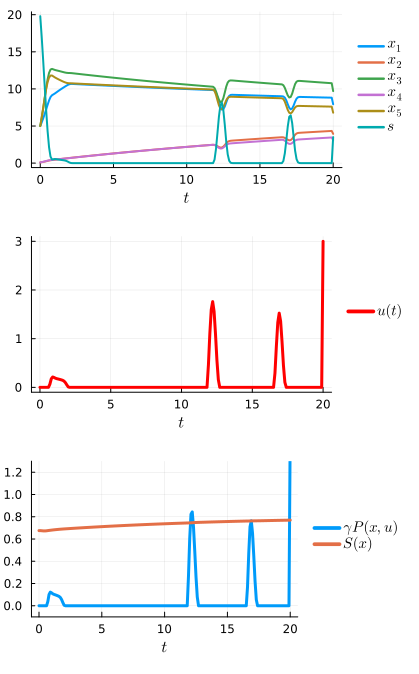

In [54]:
t, s, u  = sol.t, sol.s, sol.u
x = transpose(sol.x)
OF_list = Array{Float64}(undef, length(t), 2) # objective function values

β = 1/60 # scaling constant

for i in 1:length(t)
    x_t = x[i, :] 
    s_t = s[i]
    u_t = u[i]
    OF_list[i,:] = [P_func(u_t,x_t)*β,1-S_func(x_t)]
end
label = hcat(reshape([L"x_%$i" for i in 1:n],(1,:)),[L"s"])
p1 = plot(t, hcat(x,s), label=label, lw=2 , fg_legend = :false)#, ylimits=(0,3))
# p2 = plot(t, s, label=L"s(t)", lw=3, linecolor="orange") 
p3 = plot(t, u, label=L"u(t)", lw=3, linecolor="red", left_margin = 3mm, ylimits=(-0.1,3.1))
p4 = plot(t, OF_list, label=[L"\gamma P(x,u)\ " L"S(x)"], lw=3, ylimits=(-0.1,1.3))

# p = plot(p1, p2, p3, p4, layout=(4,1), size=(420, 900),legendfont = font(10),
#         xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)
p = plot(p1, p3, p4, layout=(3,1), size=(420,675),legendfont = font(10),
        xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)
# p = plot(p3, p4, layout=(2,1), size=(420,450),legendfont = font(10),
#         xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)

In [6]:
using DelimitedFiles
using Dates

"""
    run_chemostat_batch(simulation_configs; output_dir="results")

Run multiple CHEMOSTAT simulations with different parameters and save results.

# Arguments
- `simulation_configs`: Vector of NamedTuples with fields:
  - `name`: Simulation identifier (e.g., "sim_001")
  - `x0`: Initial species concentrations
  - `epsilon`: ε parameter
  - `alpha`: α parameter  
  - `tf`: Final time
  - Other optional parameters: `beta`, `gamma`, `model`, `s0`, `y0`, `umin`, `umax`, `nsteps`
- `output_dir`: Directory to save results (default: "results")

# Returns
- `results_summary`: DataFrame with simulation outcomes


"""
function run_chemostat_batch(simulation_configs; output_dir="default")
    output_dir = "results/"*String(output_dir)
    # Create output directory if it doesn't exist
    if !isdir(output_dir)
        mkdir(output_dir)
        println("Created directory: $output_dir")
    end
    
    # Results summary
    results_summary = []
    
    println("\n" * "="^70)
    println("BATCH SIMULATION RUNNER")
    println("="^70)
    println("Total simulations: $(length(simulation_configs))")
    println("Output directory: $output_dir")
    println("="^70 * "\n")
    
    for (idx, config) in enumerate(simulation_configs)
        sim_name = config.name
        println("[$idx/$(length(simulation_configs))] Running: $sim_name")
        println("-"^70)
        
        try
            # Extract parameters with defaults
            x0 = config.x0
            ε = config.epsilon
            α = config.alpha
            tf = config.tf
            β = haskey(config, :beta) ? config.beta : 0.0
            γ = haskey(config, :gamma) ? config.gamma : 0.001
            model = haskey(config, :model) ? config.model : 1
            s0 = haskey(config, :s0) ? config.s0 : s_in-sum(x0)
            y0 = haskey(config, :y0) ? config.y0 : 0.0
            umin = haskey(config, :umin) ? config.umin : 0.0
            umax = haskey(config, :umax) ? config.umax : 3.0
            nsteps = haskey(config, :nsteps) ? config.nsteps : Int(10*tf)
            tol = haskey(config, :tol) ? config.tol : 1e-6
            max_iter = haskey(config, :max_iter) ? config.max_iter : 50000

            # Run simulation
            start_time = now()
            sol, status = CHEMOSTAT(
                model=model,
                params=(ε, α, β, γ),
                tf=tf,
                umin=umin,
                umax=umax,
                x0=x0,
                s0=s0,
                y0=y0,
                nsteps=nsteps,
                tol=tol,
                max_iter=max_iter,  
                display=false  # Suppress output for batch runs
            )
            elapsed = Dates.value(now() - start_time) / 1000  # seconds
            
            # Compute P and S from solution
            n_species = size(sol.x, 1)
            n_time = length(sol.t)
            P = zeros(n_time)
            S = zeros(n_time)
            
            ####
            t, s, u  = sol.t, sol.s, sol.u
            x = transpose(sol.x)
            OF_list = Array{Float64}(undef, length(t), 2) # objective function values

            β = 1/60 # scaling constant

            for i in 1:length(t)
                x_t = x[i, :] 
                s_t = s[i]
                u_t = u[i]
                OF_list[i,:] = [P_func(u_t,x_t)*β,1-S_func(x_t)]
            end
            ####


            for j in 1:n_time
                P[j] = P_func(sol.u[j], sol.x[:, j])/60.0
                S[j] = 1-S_func(sol.x[:, j])
            end
            
            # Save results to CSV
            output_file = joinpath(output_dir, "$(sim_name).csv")
            
            # Prepare data matrix: [t, x1, x2, ..., xn, s, u, P, S]
            x_transposed = collect(sol.x')
            
            data = hcat(
                sol.t,
                x_transposed,
                sol.s,
                sol.u,
                P,
                S
            )
            
            # Create header
            x_headers = ["x$i" for i in 1:n_species]
            header = vcat(["t"], x_headers, ["s", "u", "P", "S"])
            
            
            # Write to file with header
            open(output_file, "w") do io
                # Write header
                write(io, join(header, ",") * "\n")
                # Write data
                writedlm(io, data, ',')
            end
            
            # Save metadata
            metadata_file = joinpath(output_dir, "$(sim_name)_metadata.txt")
            open(metadata_file, "w") do io
                println(io, "Simulation: $sim_name")
                println(io, "Date: $(now())")
                println(io, "Status: $status")
                println(io, "Elapsed time: $(round(elapsed, digits=2)) seconds")
                println(io, "\nParameters:")
                println(io, "  model: $model")
                println(io, "  ε: $ε")
                println(io, "  α: $α")
                println(io, "  β: $β")
                println(io, "  γ: $γ")
                println(io, "  tf: $tf")
                println(io, "  x0: $x0")
                println(io, "  s0: $s0")
                println(io, "  y0: $y0")
                println(io, "  umin: $umin")
                println(io, "  umax: $umax")
                println(io, "  nsteps: $nsteps")
                println(io, "\nFinal values:")
                println(io, "  P(tf): $(P[end])")
                println(io, "  S(tf): $(S[end])")
                println(io, "  s(tf): $(sol.s[end])")
            end
            
            # Add to summary
            push!(results_summary, (
                name = sim_name,
                status = status,
                elapsed = elapsed,
                P_final = P[end],
                S_final = S[end],
                file = output_file
            ))
            
            println("  ✓ Success! Status: $status")
            println("  → Saved to: $output_file")
            println("  → Time: $(round(elapsed, digits=2))s")
            
        catch e
            println("  ✗ Failed with error:")
            println("    ", e)
            
            push!(results_summary, (
                name = sim_name,
                status = "ERROR",
                elapsed = 0.0,
                P_final = NaN,
                S_final = NaN,
                file = ""
            ))
        end
        
        println()
    end
    
    # Print summary
    println("="^70)
    println("BATCH SIMULATION SUMMARY")
    println("="^70)
    
    successful = sum(r.status != "ERROR" for r in results_summary)
    println("Successful: $successful / $(length(results_summary))")
    println("\nResults saved in: $output_dir")
    println("="^70 * "\n")
    
    return results_summary
end


run_chemostat_batch

In [71]:
# Diversity simulations batch

x0_list = [ [10.0, 0.1, 0.1, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 10.0] ]
configs = [] 

for i in 1:3, tf in [40]
    name = "IC"*string(i)*"-T"*string(tf)
    x0 = x0_list[i]
    configs = vcat(configs, (name=name, model=2, x0=x0, epsilon=0.01, alpha=0.0, beta=1.0, gamma=0.01, tf=tf, tol = 1e-6, max_iter = 100000))
end; 

results = run_chemostat_batch(configs, output_dir="diversity");


BATCH SIMULATION RUNNER
Total simulations: 3
Output directory: results/diversity

[1/3] Running: IC1-T40
----------------------------------------------------------------------
  ✓ Success! Status: TIME_LIMIT
  → Saved to: results/diversity/IC1-T40.csv
  → Time: 302.85s

[2/3] Running: IC2-T40
----------------------------------------------------------------------
  ✓ Success! Status: TIME_LIMIT
  → Saved to: results/diversity/IC2-T40.csv
  → Time: 302.53s

[3/3] Running: IC3-T40
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/diversity/IC3-T40.csv
  → Time: 182.8s

BATCH SIMULATION SUMMARY
Successful: 3 / 3

Results saved in: results/diversity



In [ ]:
# Production simulations batch
x0_list = [ [10.0, 0.1, 0.1, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 10.0] ]
configs = []

for i in 1:3, tf in [10,20,30,40]
    name = "IC"*string(i)*"-T"*string(tf)
    x0 = x0_list[i]
    configs = vcat(configs, (name=name, model=1, x0=x0, epsilon=0.01, alpha=1.0, beta=0.0, gamma=0.01, tf=tf, tol = 1e-8, max_iter = 100000))
end; 

results = run_chemostat_batch(configs, output_dir="production");


BATCH SIMULATION RUNNER
Total simulations: 12
Output directory: results/production

[1/12] Running: IC1-T10
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/production/IC1-T10.csv
  → Time: 0.59s

[2/12] Running: IC1-T20
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/production/IC1-T20.csv
  → Time: 1.42s

[3/12] Running: IC1-T30
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/production/IC1-T30.csv
  → Time: 8.48s

[4/12] Running: IC1-T40
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/production/IC1-T40.csv
  → Time: 32.83s

[5/12] Running: IC2-T10
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved t

In [7]:
# Both criteria simulations batch
x0_list = [ [10.0, 0.1, 0.1, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 0.1],
            [10.0, 0.1, 10.0, 0.1, 10.0] ]
configs = []

for i in 1:3, tf in [10,20,30,40]
    x0 = x0_list[i]
    for beta in [0.2, 0.4, 0.6, 0.8]
        alpha = (1.0 - beta)/60.0
        name = "IC"*string(i)*"-T"*string(tf)*"-a"*string(Int(floor((1-beta)*10)))*"-b"*string(Int(floor(beta*10)))
        configs = vcat(configs, (name=name, model=0, x0=x0, epsilon=0.01, alpha=alpha, beta=beta, gamma=0.01, tf=tf, tol = 1e-6, max_iter = 100000))
    end
end; 

results = run_chemostat_batch(configs, output_dir="both");


BATCH SIMULATION RUNNER
Total simulations: 48
Output directory: results/both

[1/48] Running: IC1-T10-a8-b2
----------------------------------------------------------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/both/IC1-T10-a8-b2.csv
  → Time: 5.35s

[2/48] Running: IC1-T10-a6-b4
----------------------------------------------------------------------
  ✓ Success! Status: LOCALLY_SOLVED
  → Saved to: results/both/IC1-T10-a6-b4.csv
  → Time: 3.12s

[3/48] Running: IC1-T10-a4-b6
----------------------------------------------------------------------
  ✓ Success! Status: ALMOST_LOCALLY

In [ ]:

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

"""
Example configurations for batch simulations.
Modify these according to your needs.
"""
function example_batch_simulations()
    # Define your simulation configurations
    configs = [
        # Baseline simulation
        (
            name = "baseline",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.0,
            alpha = 1.0,
            tf = 30.0,
            gamma = 0.1
        ),
        
        # Varying epsilon
        (
            name = "epsilon_low",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.1,
            alpha = 1.0,
            tf = 30.0,
            gamma = 0.1
        ),
        (
            name = "epsilon_high",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.5,
            alpha = 1.0,
            tf = 30.0,
            gamma = 0.1
        ),
        
        # Varying alpha
        (
            name = "alpha_05",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.0,
            alpha = 0.5,
            tf = 30.0,
            gamma = 0.1
        ),
        (
            name = "alpha_20",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.0,
            alpha = 2.0,
            tf = 30.0,
            gamma = 0.1
        ),
        
        # Varying time horizon
        (
            name = "tf_20",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.0,
            alpha = 1.0,
            tf = 20.0,
            gamma = 0.1
        ),
        (
            name = "tf_50",
            x0 = [5.0, 6.0, 7.0, 5.0, 4.0],
            epsilon = 0.0,
            alpha = 1.0,
            tf = 50.0,
            gamma = 0.1
        ),
        
        # Different initial conditions
        (
            name = "x0_uniform",
            x0 = [5.0, 5.0, 5.0, 5.0, 5.0],
            epsilon = 0.0,
            alpha = 1.0,
            tf = 30.0,
            gamma = 0.1
        ),
        (
            name = "x0_gradient",
            x0 = [2.0, 4.0, 6.0, 8.0, 10.0],
            epsilon = 0.0,
            alpha = 1.0,
            tf = 30.0,
            gamma = 0.1
        ),
    ]
    
    # Run batch simulations
    results = run_chemostat_batch(configs, output_dir="chemostat_results")
    
    return results
end

# Uncomment to run example:
# results = example_batch_simulations()